**<div style="text-align: right;">Uqaily, Raafay</div>**

<div style="text-align: right"> Student ID: 12225382 </div>

**FINM 33150 - Quantitative Trading Strategies**
<br>
Winter 2024

<h2><center> Homework 4: Return Predictions From Trade Flow Strategy </center></h2>

<h2> 1. Introduction </h2>
<br>
This assignment required the assessment of trade flow as a means of generating profit opportunities in 3 separate cryptotoken markets. The 3 markets include: BTC-USD, ETH-USD, and ETH-BTC. At high data rates like those provided in the data, and given the markets’ price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray. 
<br>
<br>
In the context of trading, "flow volume" typically refers to the quantity of a security traded over a specific period. It's a measure of market activity and liquidity for that security, indicating how many units were bought and sold. Understanding flow volume can provide insights into the market's interest in a particular security and potentially its price movement direction. High flow volume typically indicates high liquidity, meaning the security can be bought or sold in significant quantities without a significant impact on its price. Volume data can also be particularly helpful to gauge market sentiment. For instance, unusual increases in volume may suggest that something significant is happening with the security or within its sector, prompting further analysis. For this assignment specificially, we defined flow as the difference in trading volume between buyers and sellers. After calculating the flow volume, findings were then regressed in order to predict returns and track Profit and Loss (PnL) opportunities. The equation for flow has been defined below:
<br>
<br>
$F = V^{Buy}_{(t - \tau,t)} - V^{Sell}_{(t - \tau,t)}$

### Import Statements

In [144]:
import os
import datetime
import warnings
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from collections import defaultdict

### Helper Functions

In [2]:
def performance_summary(data, columns=None):
    """
    Returns the Performance Stats for specified columns of a given set of data.
    
    Inputs: 
        data - DataFrame with corresponding financial data.
        columns - List of column names to calculate statistics for.
    
    Output:
        summary_stats - DataFrame with summary statistics for specified columns.
    """

    if columns is None:
        columns = data.columns
        
    summary_stats = pd.DataFrame(index=columns)
    for column in columns:
        # Calculate statistics for each specified column
        summary_stats.loc[column, 'Mean'] = data[column].mean()
        summary_stats.loc[column, 'Median'] = data[column].median()
        summary_stats.loc[column, 'Volatility'] = data[column].std()
        summary_stats.loc[column, 'Sharpe Ratio'] = summary_stats.loc[column, 'Mean'] / summary_stats.loc[column, 'Volatility']
        summary_stats.loc[column, 'Skewness'] = data[column].skew()
        summary_stats.loc[column, 'Excess Kurtosis'] = data[column].kurtosis()
        summary_stats.loc[column, 'Min'] = data[column].min()
        summary_stats.loc[column, 'Max'] = data[column].max()
        
        # Assuming wealth_index and drawdown calculations are not needed for each column, omit or adjust this part
        
        # Calculate VaR and CVaR at 95% confidence level
        confidence_level = 0.95
        var_95 = data[column].quantile(1 - confidence_level)
        cvar_95 = data[column][data[column] <= var_95].mean()
        
        summary_stats.loc[column, 'VaR 95%'] = var_95
        summary_stats.loc[column, 'CVaR 95%'] = cvar_95

    return summary_stats

In [3]:
def price_plot(data, pair_name):
    '''
    Returns the Price plot for a given cryptotoken pair.
    
    Input: 
        data - DataFrame with corresponding financial data.
    
    Output:
        Plot with visualization of price over time.
    '''
    
    fig, ax = plt.subplots(figsize=(16, 8))

    price = data['PriceMillionths']

    ax.plot(price, color='royalblue') 
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f'Price over Time for {pair_name}', fontsize=16)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Price (Millionths)', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
    plt.show()

In [15]:
def size_plot(data, pair_name):
    """
    Returns the 'AdjustedSize' plot for a given cryptotoken pair based on the 'Side',
    aggregated by 30-minute intervals.
    
    Input: 
        data - DataFrame with 'AdjustedSize', 'Side', and a datetime index.
    
    Output:
        Bar graph visualization of AdjustedSize over time.
    """
    
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    data_resampled = data.resample('30T').agg({'AdjustedSize': 'sum', 'Side': 'first'})
    
    data_buy = data_resampled[data_resampled['Side'] == 1]
    data_sell = data_resampled[data_resampled['Side'] == -1]
    
    plt.figure(figsize=(16, 8))
    
    plt.bar(data_buy.index, data_buy['AdjustedSize'], width=0.01, color='green', label='Buy Volume')
    plt.bar(data_sell.index, data_sell['AdjustedSize'], width=0.01, color='red', label='Sell Volume')
    
    plt.title(f'Trade Size over Time for {pair_name} (30-minute intervals)', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Trade Size (Billionths)', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [175]:
def trade_flow_regression_strategy(tau, T, book_data, trade_data):
    tau = pd.to_timedelta(tau, 's')
    T = pd.to_timedelta(T, 's')

    book_data = book_data[['Mid']]
    book_data['Time'] = book_data.index + T

    pivoted_trades = trade_data.pivot(columns='Side')['SizeBillionths']
    aggregated_trades = pivoted_trades.groupby(trade_data.index).agg({-1: 'sum', 1: 'sum'}).shift()
    rolling_trades = aggregated_trades.rolling(window=tau).sum()

    tradeFlow = rolling_trades.rename(columns={-1: 'Sell Trade Flow', 1: 'Buy Trade Flow'})
    tradeFlow['Net Trade Flow'] = tradeFlow['Buy Trade Flow'].fillna(0) - tradeFlow['Sell Trade Flow'].fillna(0)
    tradeFlow = tradeFlow.merge(trade_data['PriceMillionths'], how='left', left_index=True, right_index=True)

    merged_book = pd.merge_asof(tradeFlow, book_data, left_index=True, right_on='Time')
    strategy = merged_book.dropna()
    strategy['Return'] = np.log(strategy['Mid']) - np.log(strategy['PriceMillionths'])

    cut_off_index = int(0.4 * len(strategy))
    trainStrategy = strategy.iloc[:cut_off_index].copy()
    testStrategy = strategy.iloc[cut_off_index:].copy()

    linearModel = sm.OLS(trainStrategy['Return'], trainStrategy['Net Trade Flow']).fit()

    print(linearModel.summary())

    trainStrategy['Predicted Return'] = linearModel.predict(trainStrategy['Net Trade Flow'])
    testStrategy['Predicted Return'] = linearModel.predict(testStrategy['Net Trade Flow'])

    correlation = trainStrategy['Return'].corr(trainStrategy['Predicted Return'])
    x = np.linspace(trainStrategy['Net Trade Flow'].min(), trainStrategy['Net Trade Flow'].max(), 100)
    y = linearModel.params['Net Trade Flow'] * x

    plt.figure(figsize=(8, 6))
    plt.scatter(trainStrategy['Return'], trainStrategy['Predicted Return'], color='blue', label='Data Points')
    plt.plot(x, y, color='red', label='Regression Line')
    plt.title('Log Return vs Predicted Log Return with Regression Line')
    plt.xlabel('Log Return')
    plt.ylabel('Predicted Log Return')
    plt.text(x=max(trainStrategy['Return']) * 0.8, y=max(trainStrategy['Predicted Return']) * 0.1, 
             s=f'Correlation: {correlation:.2f}', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.legend()
    plt.show()
    
    return trainStrategy, testStrategy, linearModel.summary()

In [189]:
def calculate_return_metrics(strategy):
    optimal_j = 0.00023

    transactions_mask = strategy['Net Trade Flow'].abs() > optimal_j

    PnL = strategy.loc[transactions_mask, 'Return'].abs().sum()
    num_of_transactions = transactions_mask.sum()

    Return_pct = (PnL * 100 / num_of_transactions) if num_of_transactions else 0
    transaction_costs = [0, 0.0001, 0.01]
    PnL_adjusted = [PnL - num_of_transactions * cost for cost in transaction_costs]
    Return_pct_adjusted = [(pnl * 100 / num_of_transactions) if num_of_transactions else 0 for pnl in PnL_adjusted]

    index = ['0% Trading cost', '0.01% trading cost', '1% trading cost']
    result = pd.DataFrame({
        'Profit and Loss (PnL)': PnL_adjusted,
        'Return on Investment (%)': Return_pct_adjusted
    }, index=index)

    return result

## 2. Data Extraction

<span style="color: rgb(0, 0, 128);"> The codes below extract trade and book data for all 3 crytotoken markets. </span>

### 2.1 BTC-USD

#### Trade Data

<span style="color: rgb(0, 0, 128);"> The code below extracts trade data for the BTC-USD pair from the 'trades_narrow_BTC-USD_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index, NA values are dropped, and the "Side" column is adjusted to accurately reflect "buy" vs "sell" positions as 1 and -1 respectively. Then, summary statistics and basic visualizations are presented along with commentary on major trends for the pair. </span> 

In [86]:
trades_narrow_BTC_USD = pd.read_csv('trades_narrow_BTC-USD_2023.delim.gz', sep='\t')

trades_narrow_BTC_USD = trades_narrow_BTC_USD.drop(columns='received_utc_nanoseconds')
trades_narrow_BTC_USD['timestamp_utc_nanoseconds'] = pd.to_datetime(trades_narrow_BTC_USD['timestamp_utc_nanoseconds'])
trades_narrow_BTC_USD = trades_narrow_BTC_USD.set_index('timestamp_utc_nanoseconds')
trades_narrow_BTC_USD = trades_narrow_BTC_USD.dropna()
trades_narrow_BTC_USD = trades_narrow_BTC_USD[~trades_narrow_BTC_USD.index.duplicated(keep='first')]

trades_narrow_BTC_USD['Side'] = np.sign(trades_narrow_BTC_USD['Side'])

trades_narrow_BTC_USD

,PriceMillionths,SizeBillionths,Side
timestamp_utc_nanoseconds,,,
2023-01-24 00:47:47.874527,22970120000,87069600,-1
2023-01-24 00:47:47.878712,22970120000,10,-1
2023-01-24 00:47:47.886114,22969160000,217683140,-1
2023-01-24 00:47:48.676444,22969840000,10000000,1
2023-01-24 00:47:48.812951,22967670000,1318360,-1
...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1
2023-01-25 15:50:01.543105,22571970000,335000000,-1
2023-01-25 15:50:01.601688,22570920000,50000000,-1


In [10]:
BTC_USD_trade_columns = ['PriceMillionths', 'SizeBillionths']
performance_summary(trades_narrow_BTC_USD, BTC_USD_trade_columns)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
PriceMillionths,2.284198e+10,2.289284e+10,1.924850e+08,118.668871,-0.361760,-1.035680,2.233862e+10,2.316556e+10,2.251777e+10,2.246868e+10
SizeBillionths,7.164636e+07,1.227433e+07,1.825450e+08,0.392486,16.263338,1186.161577,1.000000e+01,2.744100e+10,1.646000e+04,5.958178e+03


<span style="color: rgb(255,69,0);"> Mean: For PriceMillionths, the mean is approximately 2.28e+10, and for SizeBillionths, it is about 7.16e+07.</span>

<span style="color: rgb(255,69,0);">Median: The median for PriceMillionths is approximately 2.29e+10, and for SizeBillionths, it is about 1.22e+07. Since the mean and median are close for PriceMillionths, the data might be symmetrically distributed around the central value. However, for SizeBillionths, the median is significantly lower than the mean, indicating a right-skewed distribution.</span>

<span style="color: rgb(255,69,0);">Volatility: For PriceMillionths, the volatility is around 1.92e+08, and for SizeBillionths, it is about 1.82e+08. This suggests that both variables experience a significant amount of fluctuation.</span>

<span style="color: rgb(255,69,0);">Sharpe Ratio: PriceMillionths has a Sharpe Ratio of approximately 118.668871, which is extraordinarily high and may suggest an unusual dataset. For SizeBillionths, the Sharpe Ratio is around 0.392486.</span>

<span style="color: rgb(255,69,0);">Skewness: A measure of the asymmetry in the distribution of data. PriceMillionths has a skewness of -0.361760, indicating a slight left skew. SizeBillionths has a significant skewness of 16.263338, indicating a highly right-skewed distribution (long tail to the right).</span>

<span style="color: rgb(255,69,0);">Excess Kurtosis: A measure of the 'tailedness' of the distribution compared to a normal distribution. PriceMillionths has a slight negative excess kurtosis, suggesting a distribution with fewer and less extreme outliers than a normal distribution. SizeBillionths has a very high positive excess kurtosis, indicating a distribution with very pronounced tails, suggesting a high likelihood of outliers.</span>

<span style="color: rgb(255,69,0);">VaR 95%: It is an estimate of the maximum loss that might be expected to occur with a 5% chance. PriceMillionths has a VaR 95% of 2.251777e+10, and SizeBillionths has a VaR 95% of 1.640000e+04.</span>

<span style="color: rgb(255,69,0);">CVaR 95%: It is an estimate of the expected loss occurring beyond the VaR level within that 5% tail of the distribution. PriceMillionths has a CVaR 95% of 2.246868e+10, and SizeBillionths has a CVaR 95% of 5.958178e+03. </span>

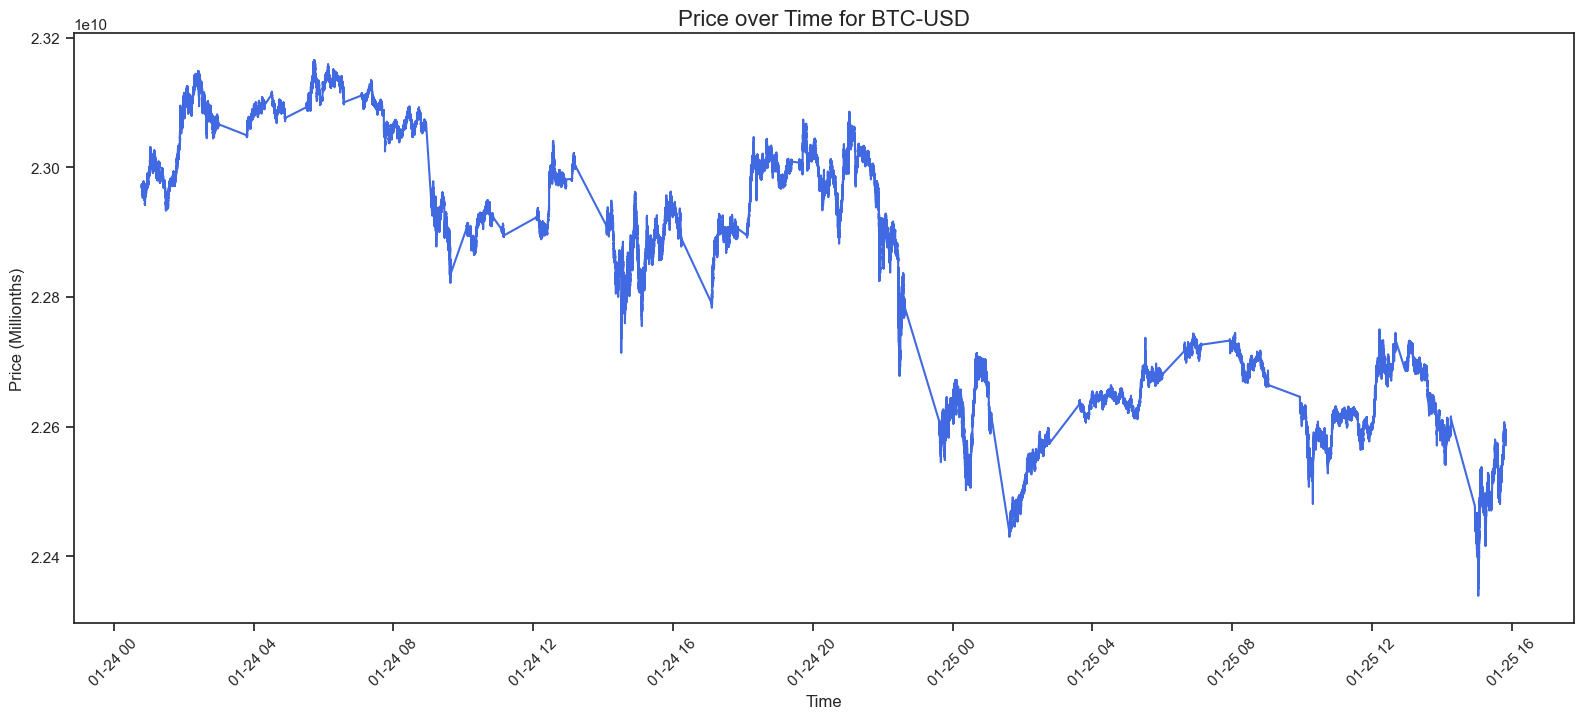

In [11]:
price_plot(trades_narrow_BTC_USD, 'BTC-USD')

<span style="color: rgb(255,69,0);"> The graph above shows the price chart for Bitcoin against the US dollar (BTC-USD). The graph shows volatility within the time period as the price oscillates. It starts at a high point, decreases, then goes up again forming a peak before falling significantly, suggesting a sharp sell-off. After that, the price partially recovers, suggesting some buying interest following the sell-off, but it does not return to the initial levels within this time frame. </span> 

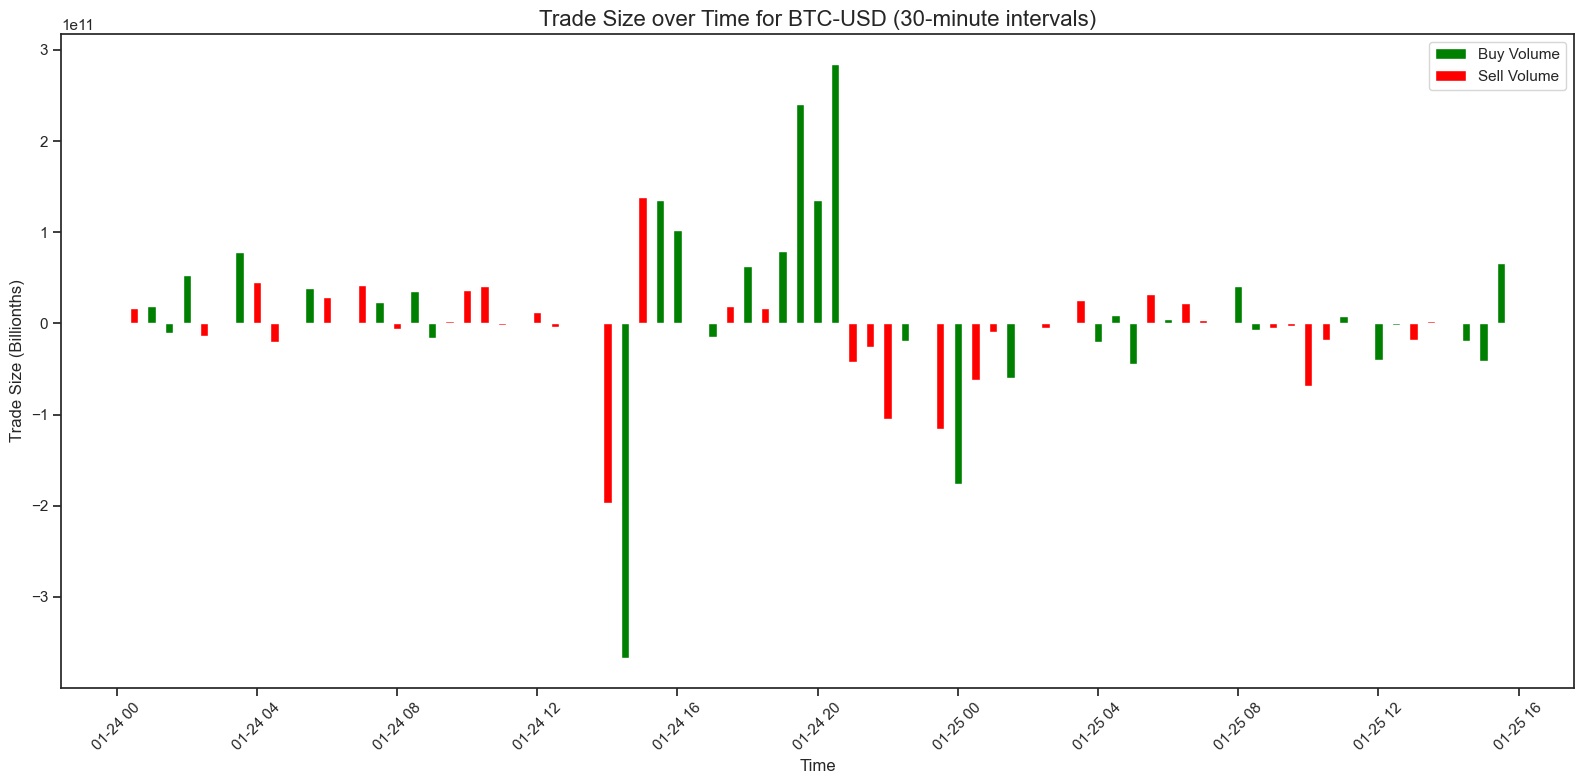

In [16]:
trades_narrow_BTC_USD['AdjustedSize'] = trades_narrow_BTC_USD['SizeBillionths'] * trades_narrow_BTC_USD['Side']
size_plot(trades_narrow_BTC_USD, 'BTC-USD')

<span style="color: rgb(255,69,0);"> The graph above shows the volume bar chart for Bitcoin against the US dollar (BTC-USD) with 30 minute intervals. Analyzing the chart, there are several periods of significant trading activity. Notably, there are large green bars, which suggests a period of heavy buying, followed by moderate red bars, indicating a subsequent period of relatively high selling. These could be reactions to market news, a large trader's actions, or other market dynamics. The buying and selling appear to be quite reactive, with no sustained periods of only buying or only selling. The chart also suggests a market with high volatility, as indicated by the large swings between buying and selling volume. </span> 

#### Book Data

<span style="color: rgb(0, 0, 128);"> The code below extracts book data for the BTC-USD pair from the 'book_narrow_BTC-USD_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, and 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index. Then, summary statistics and basic visualizations are presented. </span> 

In [85]:
book_narrow_BTC_USD = pd.read_csv('book_narrow_BTC-USD_2023.delim.gz', sep='\t')

book_narrow_BTC_USD = book_narrow_BTC_USD.drop(columns='received_utc_nanoseconds')
book_narrow_BTC_USD['timestamp_utc_nanoseconds'] = pd.to_datetime(book_narrow_BTC_USD['timestamp_utc_nanoseconds'])
book_narrow_BTC_USD = book_narrow_BTC_USD.set_index('timestamp_utc_nanoseconds')
book_narrow_BTC_USD = book_narrow_BTC_USD[~book_narrow_BTC_USD.index.duplicated(keep='first')]

book_narrow_BTC_USD

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,Mid
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-24 00:47:47.806932,22972550000,22970150000,210000000,25797600,22972560000,22970120000,210000000,87069610,2.297135e+10
2023-01-24 00:47:47.807073,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,2.297135e+10
2023-01-24 00:47:47.813516,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,2.297135e+10
2023-01-24 00:47:47.819272,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,2.297134e+10
2023-01-24 00:47:47.825538,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,2.297134e+10
...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.834922,22571340000,22569880000,85809220,100000000,22571350000,22569440000,155580,200000000,2.257061e+10
2023-01-25 15:50:01.846675,22571340000,22569880000,85809220,100000000,22571350000,22569440000,12801710,200000000,2.257061e+10
2023-01-25 15:50:01.855921,22571340000,22569880000,85809220,100000000,22571350000,22569440000,12801710,200000000,2.257061e+10


In [18]:
performance_summary(book_narrow_BTC_USD)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
Ask1PriceMillionths,2.281891e+10,2.287972e+10,2.053161e+08,111.140385,-0.205176,-1.320966,2.234180e+10,2.316556e+10,2.251147e+10,2.246819e+10
Bid1PriceMillionths,2.283452e+10,2.289945e+10,1.970495e+08,115.882161,-0.285342,-1.215212,2.233619e+10,2.316540e+10,2.250908e+10,2.246507e+10
Ask1SizeBillionths,9.467852e+07,3.984508e+07,2.769137e+08,0.341906,42.544445,3329.288683,1.000000e+01,3.850000e+10,6.502000e+04,5.353320e+04
Bid1SizeBillionths,1.149432e+08,4.400000e+07,4.980174e+08,0.230802,80.691666,10406.209361,1.000000e+01,9.866767e+10,5.132000e+04,2.757996e+04
Ask2PriceMillionths,2.282615e+10,2.287990e+10,1.978849e+08,115.350683,-0.200230,-1.245896,2.234181e+10,2.316587e+10,2.251193e+10,2.246852e+10
Bid2PriceMillionths,2.282461e+10,2.287685e+10,1.985245e+08,114.971229,-0.209168,-1.245794,2.233597e+10,2.316530e+10,2.250786e+10,2.246470e+10
Ask2SizeBillionths,1.398924e+08,6.548261e+07,3.312188e+08,0.422356,36.443842,2746.623841,1.000000e+01,3.850005e+10,3.000000e+06,1.312127e+06
Bid2SizeBillionths,1.709841e+08,7.980245e+07,7.953949e+08,0.214968,56.257425,4243.316210,1.000000e+01,9.955734e+10,3.127066e+06,1.092847e+06
Mid,2.282671e+10,2.289250e+10,2.001490e+08,114.048588,-0.235677,-1.278290,2.233910e+10,2.316548e+10,2.251084e+10,2.246665e+10


<span style="color: rgb(255,69,0);"> Mean: The mean prices are very close across Ask1, Bid1, and Mid, suggesting that the average price levels are consistent, indicative of a stable market.</span>

<span style="color: rgb(255,69,0);">Median: The median values are slightly higher than the mean values for all three, which suggests that the price distributions are almost symmetrical with a slight bias towards higher values in the middle of the dataset.</span>

<span style="color: rgb(255,69,0);">Volatility: Volatility is in a similar range for all three metrics, with Ask1 being the most volatile and Bid1 the least, indicating that ask prices fluctuated slightly more than bid prices.</span>

<span style="color: rgb(255,69,0);">Skewness: All three categories show a negative skew, but it's only slightly negative, suggesting a small number of lower-than-average values in the price distribution.</span>

<span style="color: rgb(255,69,0);">Excess Kurtosis: Negative excess kurtosis for all three suggests fewer and less severe outliers compared to a normal distribution, indicating fewer extreme price movements than might be expected in a normal market.</span>

<span style="color: rgb(255,69,0);">VaR 95%: The Value at Risk is very similar for all three, which suggests that the potential for extreme negative price movements within the 95% confidence interval is consistent across the Ask1, Bid1, and Mid prices.</span>

<span style="color: rgb(255,69,0);">In summary, the combined statistics demonstrate a market with stable mean and median prices, moderate volatility, and a slightly negative skew across the three metrics. The negative excess kurtosis across all three suggests a lower risk of extreme price deviations. The consistency of VaR across Ask1, Bid1, and Mid shows a uniform risk profile for potential downward price movements within the observed period. </span> 

### 2.2 ETH-USD

#### Trade Data

<span style="color: rgb(0, 0, 128);"> The code below extracts trade data for the ETH-USD pair from the 'trades_narrow_ETH-USD_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index, NA values are dropped, and the "Side" column is adjusted to accurately reflect "buy" vs "sell" positions as 1 and -1 respectively. Then, summary statistics and basic visualizations are presented along with commentary on major market trends for the pair. </span> 

In [84]:
trades_narrow_ETH_USD = pd.read_csv('trades_narrow_ETH-USD_2023.delim.gz', sep='\t')

trades_narrow_ETH_USD = trades_narrow_ETH_USD.drop(columns='received_utc_nanoseconds')
trades_narrow_ETH_USD['timestamp_utc_nanoseconds'] = pd.to_datetime(trades_narrow_ETH_USD['timestamp_utc_nanoseconds'])
trades_narrow_ETH_USD = trades_narrow_ETH_USD.set_index('timestamp_utc_nanoseconds')
trades_narrow_ETH_USD = trades_narrow_ETH_USD.dropna()
trades_narrow_ETH_USD = trades_narrow_ETH_USD[~trades_narrow_ETH_USD.index.duplicated(keep='first')]

trades_narrow_ETH_USD['Side'] = np.sign(trades_narrow_ETH_USD['Side'])
book_narrow_ETH_USD

trades_narrow_ETH_USD

,PriceMillionths,SizeBillionths,Side
timestamp_utc_nanoseconds,,,
2023-01-24 00:47:51.071902,1629670000,11815210,-1
2023-01-24 00:47:51.398509,1629770000,92158690,1
2023-01-24 00:47:51.578052,1629770000,92150000,1
2023-01-24 00:47:51.660995,1629770000,8690,1
2023-01-24 00:47:51.885174,1629820000,14730,1
...,...,...,...
2023-01-25 15:00:30.318655,1533310000,698007670,1
2023-01-25 15:00:30.318708,1533330000,2560936460,1
2023-01-25 15:00:30.319185,1533310000,2095786600,1


In [20]:
ETH_USD_trade_columns = ['PriceMillionths', 'SizeBillionths']
performance_summary(trades_narrow_ETH_USD, ETH_USD_trade_columns)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
PriceMillionths,1.588622e+09,1.611270e+09,3.784650e+07,41.975401,-0.090747,-1.800536,1.532690e+09,1.640540e+09,1.540050e+09,1.536852e+09
SizeBillionths,6.345828e+08,1.573535e+08,2.186991e+09,0.290163,43.649742,4399.904632,1.000000e+01,3.403621e+11,5.160000e+03,2.574518e+03


<span style="color: rgb(255,69,0);"> Mean: PriceMillionths had a mean price of 1.588622e+09 and SizeBillionths had a mean of 6.345828e+08. </span> 
    
<span style="color: rgb(255,69,0);">Median:The median of 1.611270e+09 for PriceMillionths is close to the mean, suggesting a fairly symmetrical distribution of prices. The median of 1.573535e+08 for SizeBillionths that is much lower than the mean indicates a distribution of trade sizes that is skewed by a number of very large trades.</span> 

<span style="color: rgb(255,69,0);">Volatility: The price volatility of 3.784650e+07 shows there is some level of price fluctuation but not excessively high. The trade size volatility of 2.186991e+09 is very large, suggesting that the sizes of trades vary widely, which could be indicative of a mix of both small and very large transactions.</span> 

<span style="color: rgb(255,69,0);">Sharpe Ratio: A Sharpe Ratio of 41.975401 for PriceMillionths is exceptionally high and quite unusual, indicating either an extraordinary return for each unit of risk or a potential anomaly in the data. The Sharpe Ratio of 0.290163 for SizeBillionths is much more in line with typical financial data, indicating a lower return per unit of risk for trade sizes.</span> 

<span style="color: rgb(255,69,0);">Skewness: The slight negative skewness of -0.090747 for indicates that there are not many extreme low price values pulling the distribution to the left. An extreme positive skewness for size of 43.649742 is highly unusual and suggests that there are occasional trades that are significantly larger than the rest, which could be indicative of sporadic market-moving events.</span> 

<span style="color: rgb(255,69,0);">Excess Kurtosis: With an excess kurtosis of -1.800536, the price distribution is less peaked and has lighter tails than a normal distribution, indicating a lower likelihood of extreme price movements. The extremely high excess kurtosis for size of 4399.904632 indicates a very peaked distribution with very fat tails for trade sizes, highlighting the presence of outlier trades that are much larger than the typical trade.</span> 

<span style="color: rgb(255,69,0);">VaR 95%: The VaR of 1.540050e+09 for PriceMillionths indicates that there is a 5% chance that the price could fall below approximately 1,540.050 USD. The VaR of 5.160000e+03 for SizeBillionths indicates that there is a 5% chance that the trade size could fall below 5160 units, which seems relatively small compared to the mean size. </span> 

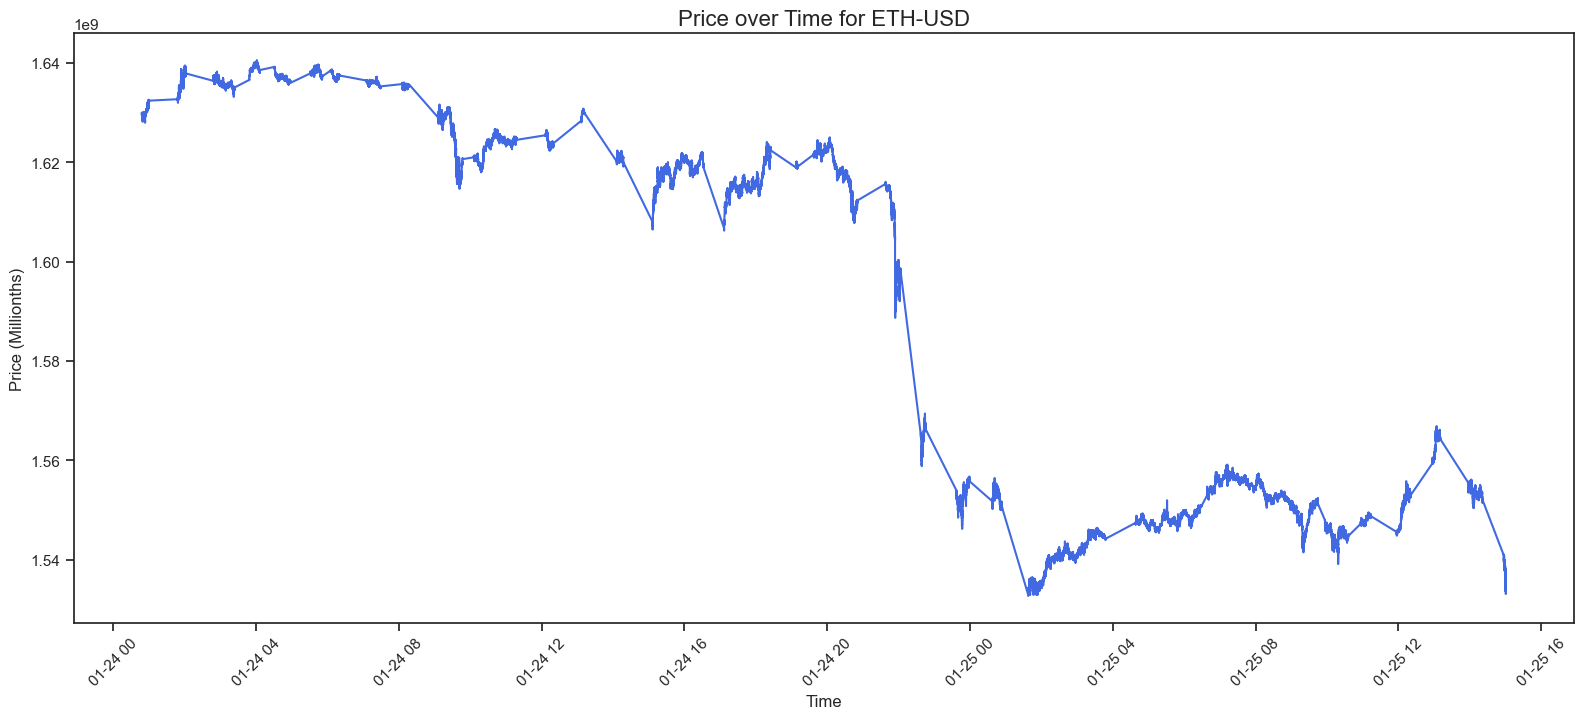

In [21]:
price_plot(trades_narrow_ETH_USD, 'ETH-USD')

<span style="color: rgb(255,69,0);"> The graph presents a snapshot of Ethereum's (ETH) price in USD, indicating initial price stability with minor fluctuations, characteristic of a consolidating market. This tranquility is abruptly interrupted by a steep price drop, a sign of sudden and intense selling pressure which could stem from various catalysts such as adverse news or significant players liquidating their holdings. Following this plummet, the price enters a phase of heightened volatility, marked by several peaks and valleys as the market seeks a new balance point. Attempts at recovery are evident as the price sporadically ascends, suggesting the presence of buyers attracted by lower prices, yet these rallies fall short of reinstating the price to its pre-drop level within the observed timespan. </span> 

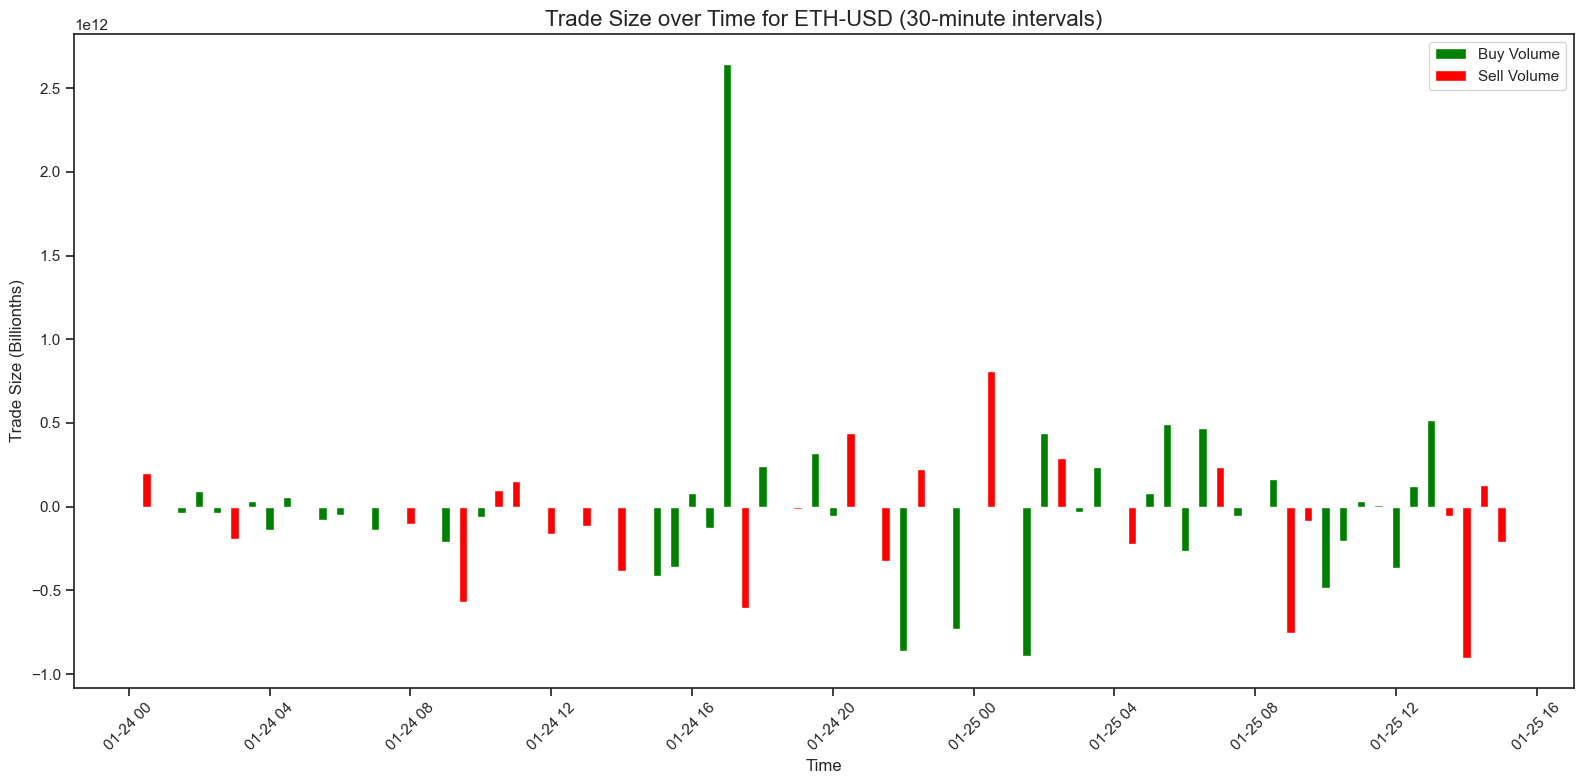

In [23]:
trades_narrow_ETH_USD['AdjustedSize'] = trades_narrow_ETH_USD['SizeBillionths'] * trades_narrow_ETH_USD['Side']
size_plot(trades_narrow_ETH_USD, 'ETH-USD')

<span style="color: rgb(255,69,0);"> The graph shows the trade size in billionths for ETH-USD transactions, broken down into 30-minute intervals. A particularly noticeable spike in the buy volume is evident at one point, dwarfing other intervals by a significant margin. This could indicate a large buy order or a series of buys that could potentially be a driver for a price increase if not immediately matched by sell orders. Throughout the rest of the graph, there is a mix of buying and selling with no clear dominance by either side, suggesting a market with balanced trade flows or indecision among traders. Periods of higher sell volume can be seen, as well as intervals where buying slightly outweighs selling, but these are relatively modest in comparison to the spike. </span> 

#### Book Data

<span style="color: rgb(0, 0, 128);"> The code below extracts book data for the ETH-USD pair from the 'book_narrow_ETH-USD_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, and 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index. Then, summary statistics and basic visualizations are presented. </span> 

In [83]:
book_narrow_ETH_USD = pd.read_csv('book_narrow_ETH-USD_2023.delim.gz', sep='\t')

book_narrow_ETH_USD = book_narrow_ETH_USD.drop(columns='received_utc_nanoseconds')
book_narrow_ETH_USD['timestamp_utc_nanoseconds'] = pd.to_datetime(book_narrow_ETH_USD['timestamp_utc_nanoseconds'])
book_narrow_ETH_USD = book_narrow_ETH_USD.set_index('timestamp_utc_nanoseconds')
book_narrow_ETH_USD = book_narrow_ETH_USD[~book_narrow_ETH_USD.index.duplicated(keep='first')]

book_narrow_ETH_USD

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,Mid
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-24 00:47:51.006006,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,40425010,1.629725e+09
2023-01-24 00:47:51.008923,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,125425010,1.629725e+09
2023-01-24 00:47:51.013030,1629780000,1629670000,613579740,346580250,1629790000,1629660000,920369620,125425010,1.629725e+09
2023-01-24 00:47:51.071902,1629780000,1629670000,613579740,334765040,1629790000,1629660000,920369620,125425010,1.629725e+09
2023-01-24 00:47:51.167792,1629770000,1629670000,92158690,334765040,1629780000,1629660000,613579740,125425010,1.629720e+09
...,...,...,...,...,...,...,...,...,...
2023-01-25 15:00:30.361372,1533340000,1535520000,2574812930,1242240,1533350000,1533040000,3192500000,27600000000,1.534430e+09
2023-01-25 15:00:30.373499,1533340000,1535520000,2574812930,1242240,1533350000,1533090000,3192500000,249890000,1.534430e+09
2023-01-25 15:00:30.374189,1533300000,1535520000,40724090,1242240,1533340000,1533090000,2574812930,249890000,1.534410e+09


In [25]:
performance_summary(book_narrow_ETH_USD)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
Ask1PriceMillionths,1.587779e+09,1.609400e+09,3.779546e+07,42.009778,-0.040647,-1.812137,1.532800e+09,1.640540e+09,1.540250e+09,1.536911e+09
Bid1PriceMillionths,1.587702e+09,1.609220e+09,3.781976e+07,41.980744,-0.040398,-1.812494,1.532690e+09,1.640330e+09,1.540150e+09,1.536764e+09
Ask1SizeBillionths,1.653612e+09,3.271957e+08,4.296760e+10,0.038485,69.879542,5302.513881,1.000000e+01,4.187039e+12,9.810000e+03,5.179072e+03
Bid1SizeBillionths,1.009181e+09,3.843947e+08,3.691056e+09,0.273413,55.084937,4506.994521,1.000000e+01,4.291783e+11,9.460000e+03,4.852943e+03
Ask2PriceMillionths,1.587811e+09,1.609460e+09,3.779307e+07,42.013294,-0.040748,-1.812148,1.532960e+09,1.640600e+09,1.540280e+09,1.536943e+09
Bid2PriceMillionths,1.587658e+09,1.609170e+09,3.782047e+07,41.978815,-0.040548,-1.812188,1.532650e+09,1.640320e+09,1.540110e+09,1.536717e+09
Ask2SizeBillionths,1.643094e+09,3.700060e+08,3.469408e+10,0.047359,96.102299,9924.238877,1.000000e+01,4.187339e+12,5.117078e+07,2.677819e+07
Bid2SizeBillionths,1.301338e+09,4.809334e+08,3.371544e+09,0.385977,44.666398,4034.259130,1.000000e+01,4.291783e+11,3.696074e+07,1.669374e+07
Mid,1.587740e+09,1.609310e+09,3.780721e+07,41.995699,-0.040558,-1.812363,1.532750e+09,1.640360e+09,1.540200e+09,1.536827e+09


<span style="color: rgb(255,69,0);"> Mean: The mean prices for Ask1, Bid1, and Mid are approximately 1.58779e+09, 1.587702e+09, and 1.587740e+09 respectively. These values are quite close to each other, suggesting a stable average price level for the market, which indicates a well-balanced market without a large spread between bid and ask prices.</span>

<span style="color: rgb(255,69,0);">Median: Median values for all three are approximately 1.609400e+09, 1.609220e+09, and 1.609310e+09, all slightly higher than their respective mean values. This slight difference between the mean and median values indicates a nearly symmetrical distribution of prices with a slight tendency towards higher values.</span>

<span style="color: rgb(255,69,0);">Volatility: Volatility is fairly similar across all three metrics, though Ask1 shows the highest volatility at 3.779546e+07 and Bid1 the lowest at 3.781976e+07, with Mid at 3.780721e+07. This suggests that Ask1 prices have a slightly higher fluctuation range than Bid1 prices, which could imply a slightly higher uncertainty or willingness to sell at varying prices.</span>

<span style="color: rgb(255,69,0);">Skewness: All three categories exhibit a very slight negative skewness, with values close to zero. This indicates that the price distribution has a longer left tail with a few lower-than-average values, but overall the distribution is quite balanced.</span>

<span style="color: rgb(255,69,0);">Excess Kurtosis: The excess kurtosis for all is negative, with values around -1.812 for Ask1 and Bid1 and -1.812363 for Mid, indicating that all distributions are less peaked than a normal distribution and have lighter tails, which implies fewer extreme deviations in prices. </span>

<span style="color: rgb(255,69,0);">VaR 95%: The Value at Risk at the 95% confidence level is consistent across Ask1, Bid1, and Mid, with values around 1.540250e+09. This uniformity in VaR suggests a similar risk of downward price movements for all three measures. </span> 

### 2.3 ETH-BTC

#### Trade Data

<span style="color: rgb(0, 0, 128);"> The code below extracts trade data for the ETH-BTC pair from the 'trades_narrow_ETH-BTC_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index, NA values are dropped, and the "Side" column is adjusted to accurately reflect "buy" vs "sell" positions as 1 and -1 respectively. Then, summary statistics and basic visualizations are presented along with commentary on major market trends for the pair. </span> 

In [79]:
trades_narrow_ETH_BTC = pd.read_csv('trades_narrow_ETH-BTC_2023.delim.gz', sep='\t')

trades_narrow_ETH_BTC = trades_narrow_ETH_BTC.drop(columns='received_utc_nanoseconds')
trades_narrow_ETH_BTC['timestamp_utc_nanoseconds'] = pd.to_datetime(trades_narrow_ETH_BTC['timestamp_utc_nanoseconds'])
trades_narrow_ETH_BTC = trades_narrow_ETH_BTC.set_index('timestamp_utc_nanoseconds').sort_index()
trades_narrow_ETH_BTC = trades_narrow_ETH_BTC.dropna()
trades_narrow_ETH_BTC = trades_narrow_ETH_BTC[~trades_narrow_ETH_BTC.index.duplicated(keep='first')]

trades_narrow_ETH_BTC['Side'] = np.sign(trades_narrow_ETH_BTC['Side'])

trades_narrow_ETH_BTC

,PriceMillionths,SizeBillionths,Side
timestamp_utc_nanoseconds,,,
2023-01-24 00:49:06.020758,70950,259656510,1
2023-01-24 00:49:06.050573,70950,140800,1
2023-01-24 00:49:08.159815,70950,53582550,-1
2023-01-24 00:49:12.601911,70940,207220,-1
2023-01-24 00:52:26.201920,70950,990630,1
...,...,...,...
2023-01-25 15:07:00.556309,68470,170840,-1
2023-01-25 15:07:13.932491,68480,83190000,-1
2023-01-25 15:07:34.076843,68490,77766040,1


In [27]:
ETH_BTC_trade_columns = ['PriceMillionths', 'SizeBillionths']
performance_summary(trades_narrow_ETH_BTC, ETH_BTC_trade_columns)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
PriceMillionths,6.964355e+04,69780.0,1.111501e+03,62.657203,-0.047269,-1.795425,68220.0,7.113000e+04,68300.0,68277.614679
SizeBillionths,8.951463e+08,84171520.0,2.366925e+09,0.378189,6.875250,71.777183,10.0,3.758155e+10,168497.5,73860.000000


<span style="color: rgb(255,69,0);"> Mean: PriceMillionths had a mean price of approximately 6.964355e+04. SizeBillionths had a mean size of approximately 8.951463e+08. </span> 
    
<span style="color: rgb(255,69,0);">Median: The median for PriceMillionths is 69780.0, closely aligned with the mean, indicating a relatively symmetrical price distribution. For SizeBillionths, the median is significantly higher compared to the mean, which indicates a right-skewed distribution, likely due to a few very large trades. </span> 

<span style="color: rgb(255,69,0);">Volatility: The price volatility is 1.111501e+03, which suggests some fluctuation in the price of PriceMillionths but not extremely high. The trade size volatility is much higher at 2.366925e+09 for SizeBillionths, indicating a large variation in trade sizes. </span> 

<span style="color: rgb(255,69,0);">Sharpe Ratio: A Sharpe Ratio of 62.657203 for PriceMillionths is very high, suggesting a high risk-adjusted return which is extraordinary for financial markets and could be an anomaly. The Sharpe Ratio for SizeBillionths is 0.378189, which is more typical and indicates a modest excess return per unit of risk for trade sizes. </span> 

<span style="color: rgb(255,69,0);">Skewness: There is a slight negative skewness of -0.047269 for PriceMillionths, implying a distribution with fewer lower-than-average values. For SizeBillionths, the positive skewness of 6.875250 indicates a long right tail in the distribution, suggesting the presence of outlier trades much larger than most. </span> 

<span style="color: rgb(255,69,0);">Excess Kurtosis: PriceMillionths has an excess kurtosis of -1.795425, indicating a distribution with fewer and less extreme outliers than a normal distribution. SizeBillionths has an extremely high excess kurtosis of 71.777183, suggesting a distribution with very heavy tails, implying significant outlier trade sizes. </span> 

<span style="color: rgb(255,69,0);">VaR 95%: The VaR for PriceMillionths at 68300.0 indicates there's a 5% chance the price could drop below this value. For SizeBillionths, the VaR at 168497.5 suggests a 5% chance that trade sizes could fall below this number, which is relatively low compared to the average trade size. </span> 
    
<span style="color: rgb(255,69,0);">CVaR 95%: The CVaR for PriceMillionths is at 68277.614679, suggesting the expected loss in the worst 5% of cases could be at least this amount. The CVaR for SizeBillionths is substantially higher at 73860.000000, indicating a higher expected loss in the worst 5% of cases for trade sizes. </span> 

<span style="color: rgb(255,69,0);">In conclusion, the PriceMillionths data suggests a market with modest price fluctuations and a very high Sharpe Ratio, which might indicate high returns relative to risk or an unusual market situation. In contrast, the SizeBillionths data shows much larger variability in trade sizes, with a distribution heavily skewed by large trades, as evidenced by the high positive skewness and excess kurtosis. The risk metrics (VaR and CVaR) for both price and size indicate a lower probability of extreme negative movements, with trade size showing a potential for larger unexpected losses. </span> 

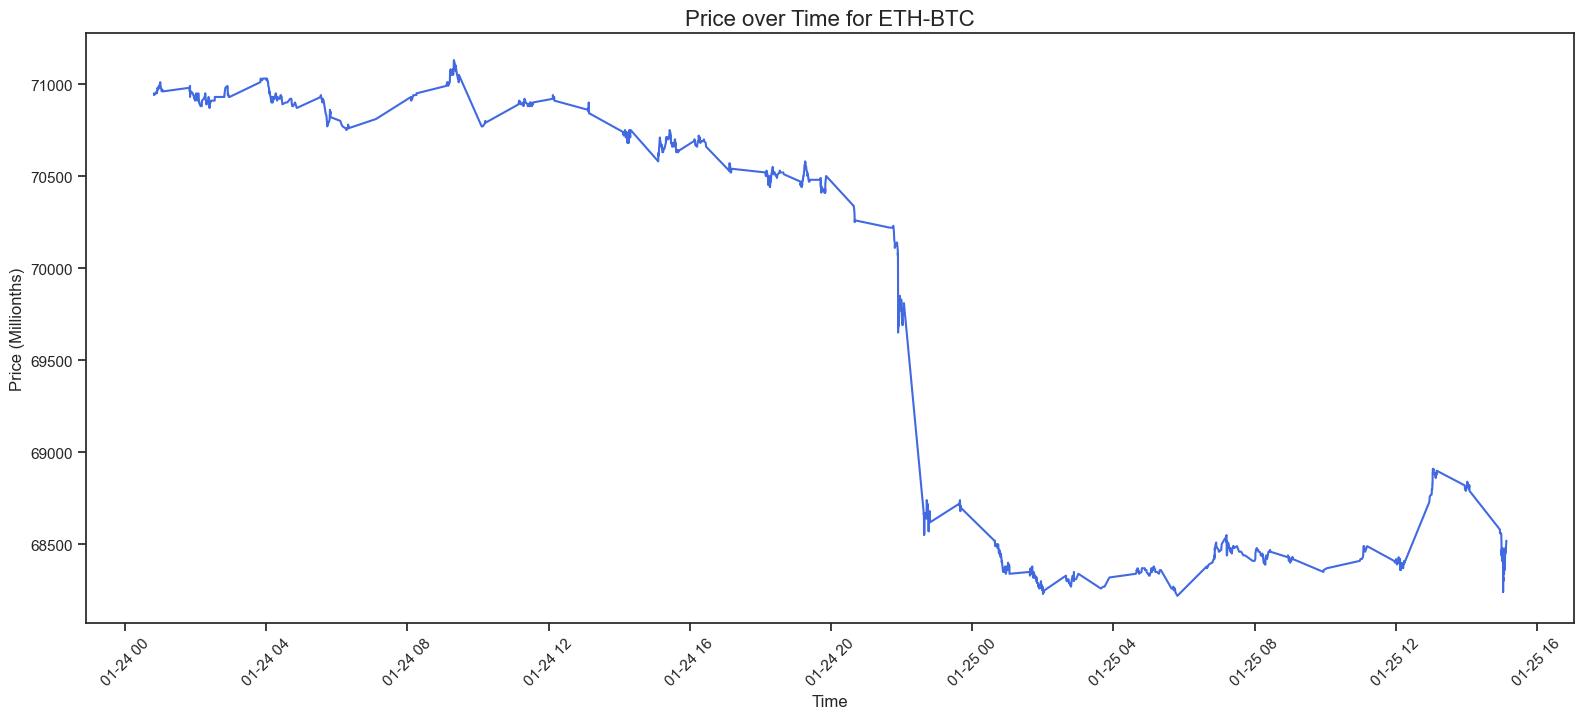

In [28]:
price_plot(trades_narrow_ETH_BTC, 'ETH-BTC')

<span style="color: rgb(255,69,0);">The graph depicts the price of Ethereum (ETH) in terms of Bitcoin (BTC), showing a significant price trend and volatility. Initially, the price is relatively stable, with minor fluctuations within a narrow band, suggesting a period of market equilibrium. This stability is abruptly disrupted by a sharp decline, indicating a strong selling pressure or a market event that caused ETH to lose value against BTC dramatically. Following this precipitous drop, the price enters a period of heightened volatility, characterized by noticeable ups and downs as the market seeks to establish a new equilibrium price. This could reflect market uncertainty or a reaction to the same event that caused the initial drop. Toward the end of the period shown, the price appears to stabilize somewhat, though at a lower level than before the drop. </span> 

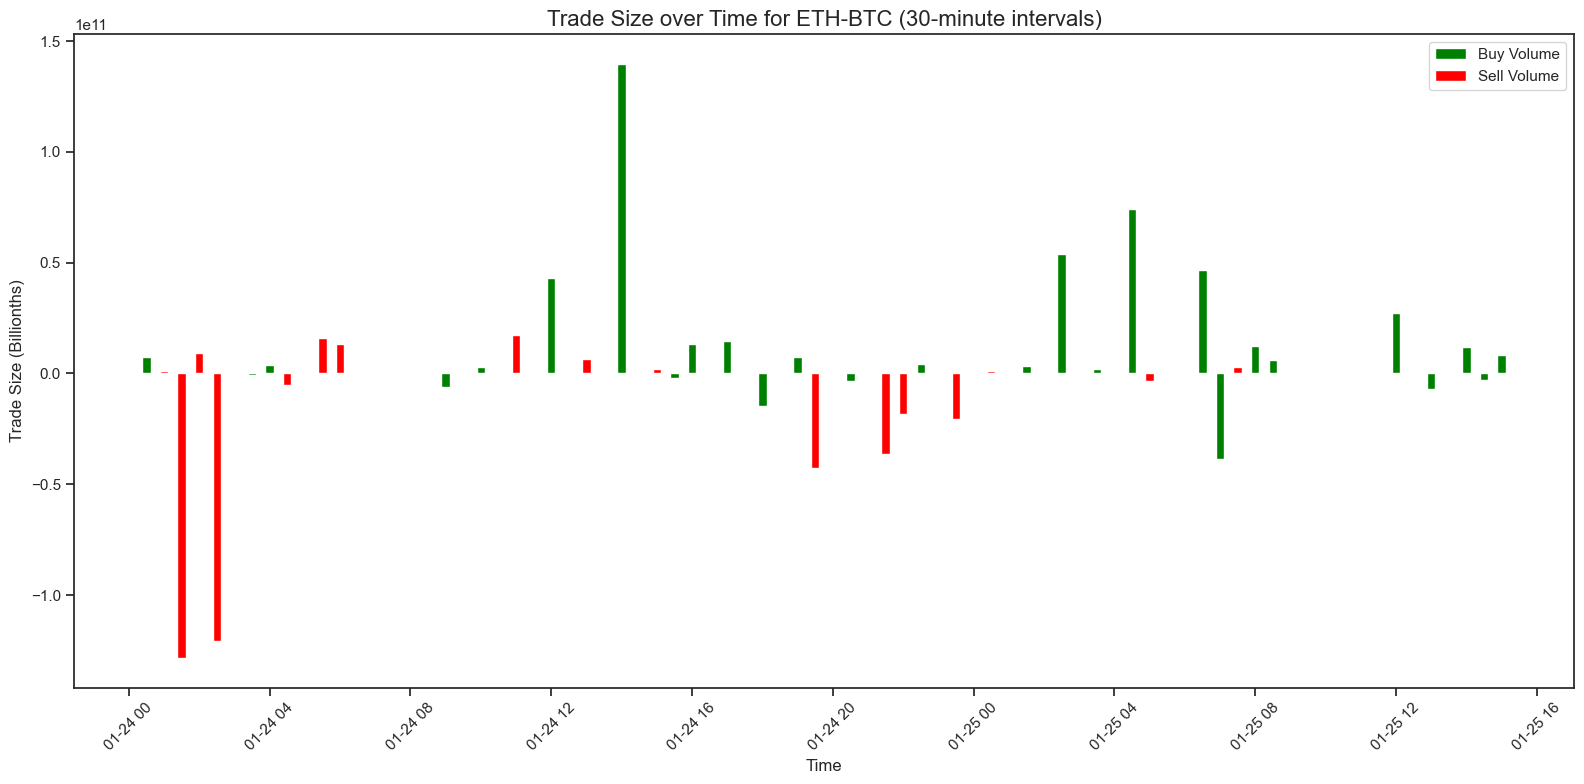

In [70]:
trades_narrow_ETH_BTC['AdjustedSize'] = trades_narrow_ETH_BTC['SizeBillionths'] * trades_narrow_ETH_BTC['Side']
size_plot(trades_narrow_ETH_BTC, 'ETH-BTC')

<span style="color: rgb(255,69,0);"> The graph illustrates the trade size for ETH-BTC in billionths over a series of 30-minute intervals, depicting the volume of buy and sell orders. Notably, there is a significant green bar, which suggests a large buy order or a collection of buy orders occurred during a particular interval, substantially outweighing sell orders. This could imply a bullish sentiment or a response to market-moving information during that period. The red bars, on the other hand, show intervals where sell orders predominated, though none match the magnitude of the largest buy spike. </span> 

#### Book Data

<span style="color: rgb(0, 0, 128);"> The code below extracts book data for the ETH-BTC pair from the 'book_narrow_ETH-BTC_2023.delim' file. The 'received_utc_nanoseconds' column is dropped, and 'timestamp_utc_nanoseconds' column is converted to datetime and set as the index. Then, summary statistics and basic visualizations are presented. </span> 

In [80]:
book_narrow_ETH_BTC = pd.read_csv('book_narrow_ETH-BTC_2023.delim.gz', sep='\t')

book_narrow_ETH_BTC = book_narrow_ETH_BTC.drop(columns='received_utc_nanoseconds')
book_narrow_ETH_BTC['timestamp_utc_nanoseconds'] = pd.to_datetime(book_narrow_ETH_BTC['timestamp_utc_nanoseconds'])
book_narrow_ETH_BTC = book_narrow_ETH_BTC.set_index('timestamp_utc_nanoseconds').sort_index()
book_narrow_ETH_BTC = book_narrow_ETH_BTC[~book_narrow_ETH_BTC.index.duplicated(keep='first')]

book_narrow_ETH_BTC

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,Mid
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-24 00:47:55.066931,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,70955.0
2023-01-24 00:47:58.159732,70970,70940,2297617430,48603840,70980,70930,13399602090,14206845420,70955.0
2023-01-24 00:47:58.171531,70970,70940,2297617430,48603840,70980,70930,13399602090,14996845420,70955.0
2023-01-24 00:47:58.173961,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,70955.0
2023-01-24 00:47:58.183694,70970,70940,1507617430,48603840,70980,70930,10629602090,14996845420,70955.0
...,...,...,...,...,...,...,...,...,...
2023-01-25 15:08:34.695712,68440,68480,1172244040,113120840,68510,68470,573666670,5945769670,68460.0
2023-01-25 15:08:34.717516,68440,68480,1172244040,113120840,68510,68470,1780735140,5945769670,68460.0
2023-01-25 15:08:34.928012,68440,68480,1172244040,113120840,68510,68470,1780735140,5945769670,68460.0


In [30]:
performance_summary(book_narrow_ETH_BTC)

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
Ask1PriceMillionths,6.977320e+04,7.048000e+04,1.125991e+03,61.966044,-0.269068,-1.796159,68220.0,7.106000e+04,68310.0,6.828022e+04
Bid1PriceMillionths,6.977697e+04,7.048000e+04,1.127267e+03,61.899215,-0.291813,-1.786478,68210.0,7.113000e+04,68290.0,6.826274e+04
Ask1SizeBillionths,2.819860e+09,1.076101e+09,5.320736e+09,0.529976,3.305553,11.734331,-18360000.0,4.389954e+10,14924990.0,6.270634e+06
Bid1SizeBillionths,1.327242e+09,1.832882e+08,3.084199e+09,0.430336,5.114598,34.303826,10.0,4.255149e+10,5985150.0,2.782385e+06
Ask2PriceMillionths,6.978572e+04,7.049000e+04,1.127235e+03,61.908740,-0.267189,-1.794042,68230.0,7.112000e+04,68320.0,6.829020e+04
Bid2PriceMillionths,6.974691e+04,7.045000e+04,1.127602e+03,61.854204,-0.265843,-1.793424,68200.0,7.112000e+04,68280.0,6.825260e+04
Ask2SizeBillionths,6.665735e+09,3.070759e+09,7.542991e+09,0.883699,1.788939,3.598791,80.0,5.383994e+10,148105470.0,7.173332e+07
Bid2SizeBillionths,6.700393e+09,3.342730e+09,7.079978e+09,0.946386,1.191933,0.956089,10.0,4.544190e+10,77905200.0,4.880897e+07
Mid,6.977508e+04,7.047000e+04,1.126134e+03,61.959866,-0.281036,-1.790740,68215.0,7.106000e+04,68300.0,6.827037e+04


<span style="color: rgb(255,69,0);"> Mean: The mean prices for Ask1, Bid1, and Mid are approximately 6.97732e+04, 6.97769e+04, and 6.97750e+04 respectively. These means are very close to each other, suggesting that the average price levels for these metrics are nearly identical, which is indicative of a stable and well-balanced market without a significant spread between the asking and bidding prices. </span> 

<span style="color: rgb(255,69,0);">Median: The median values for Ask1 and Bid1 are exactly the same at 7.048000e+04, and very close to the median for Mid at 7.047000e+04. The medians being slightly higher than the means indicate a distribution of prices that is nearly symmetrical, with a marginal bias towards higher values in the dataset. </span> 
    
<span style="color: rgb(255,69,0);">Volatility: Volatility measures for Ask1, Bid1, and Mid are 1.125991e+03, 1.127276e+03, and 1.126134e+03, respectively. The similar range in volatility suggests that price movements for Ask1, Bid1, and Mid are closely aligned, with a small range of fluctuation, indicative of a market with consistent price behavior. </span> 
    
<span style="color: rgb(255,69,0);">Skewness: All three metrics show a slight negative skewness, with Ask1 at -0.269068, Bid1 at -0.291813, and Mid at -0.281036. These values suggest a distribution with a slightly longer left tail, meaning there are fewer instances of extremely low prices. </span> 
    
<span style="color: rgb(255,69,0);">Excess Kurtosis: The excess kurtosis for all three is also negative, indicating less peaked distributions than a normal distribution and suggesting fewer and less extreme price outliers. The values are -1.796159 for Ask1, -1.786478 for Bid1, and -1.790740 for Mid. </span> 
    
<span style="color: rgb(255,69,0);">VaR 95%: The Value at Risk at the 95% confidence level for Ask1, Bid1, and Mid are very similar, with values at 68310.0, 68290.0, and 68300.0 respectively. This indicates a similar level of risk for extreme negative price movements across all three price metrics. </span> 
    
<span style="color: rgb(255,69,0);">In summary, the data for Ask1, Bid1, and Mid show a very stable market environment with consistent average price levels and similar risk profiles. The slight negative skewness and negative excess kurtosis across all metrics suggest a market that is less prone to extreme price drops, with the Value at Risk reinforcing the uniformity in potential downside risk. </span> 

## 3. Flow Trading Strategy

<span style="color: rgb(0, 0, 128);"> The codes below make use of previously-defined functions to demonstrate regression analysis and plot findings. I initially started this analysis by selecting a value of 20 seconds for tau and 10 seconds for T. </span> 

### 3.1 BTC-USD

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.046
Method:                 Least Squares   F-statistic:                              7137.
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                        0.00
Time:                        11:11:31   Log-Likelihood:                      8.8849e+05
No. Observations:              147779   AIC:                                 -1.777e+06
Df Residuals:                  147778   BIC:                                 -1.777e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

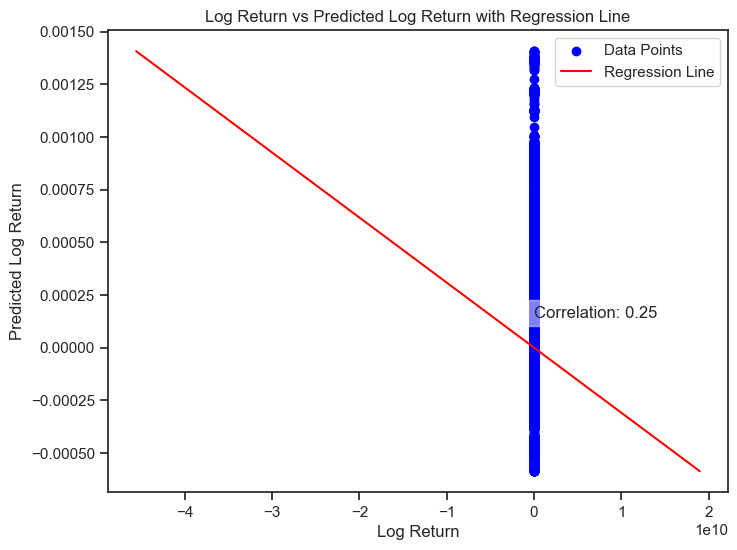

In [190]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 10, book_narrow_BTC_USD, trades_narrow_BTC_USD)

<span style="color: rgb(255,69,0);">The OLS regression results for BTC-USD show that the dependent variable, Log Return, is being modeled as a function of the independent variable, Net Trade Flow. The R-squared value is 0.046, which means that around 4.6% of the variance in Return can be explained by Net Trade Flow. This is a relatively low value. The coefficient for Net Trade Flow is -3.087e-4, which suggests that there is a small negative relationship between Net Trade Flow and Return. Specifically, for each unit increase in Net Trade Flow, there is an expected decrease in Return by approximately 0.0003087 units. However, considering the standard error is quite small (3.65e-16), the coefficient is significantly different from zero (as indicated by the p-value being less than 0.05), implying a statistically significant relationship between the predictor and the response variable. The F-statistic is also significant, indicating that the model is statistically significant and that the explained variance is not due to chance for this cryptotoken pair. </span>  

<span style="color: rgb(0, 0, 128);"> The code below explores the impact of varying a threshold parameter j on trading decisions based on predicted returns within the trainStrategy dataset. Specifically, a predicted return greater than j triggers a buy decision, less than negative j triggers a sell, and anything in between results in no action. </span> 

In [191]:
strategy_analysis = pd.DataFrame(columns=['Number of Trades', 'Trading Opportunities Capitalized (%)'])
strategy_analysis.index.name = 'j'

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]

strategy_analysis

,Number of Trades,Trading Opportunities Capitalized (%)
j,,
0.00001,27394.0,81.46
0.00003,64811.0,56.14
0.00005,89350.0,39.54
0.00007,104784.0,29.09
0.00009,115047.0,22.15
0.00011,122404.0,17.17
0.00013,127953.0,13.42
0.00015,131555.0,10.98
0.00017,134215.0,9.18


<span style="color: rgb(0, 0, 128);"> This code calculates and compares the profitability and return on investment (ROI) under different transaction cost scenarios. It first filters trades where the absolute value of the "Net Trade Flow" exceeds a specified threshold (optimal_j). Then, it calculates the total profit or loss (PnL) and the number of transactions that passed this filter. The ROI is computed as a percentage of the PnL relative to the number of transactions. The j value from the table above, with the closest trading opportunity capitalization rate to 5% is chosen. </span>  

In [195]:
closest_j = None
closest_capitalized = None
closest_result = None
closest_difference = float('inf')

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]
    
    # Calculate return metrics for each iteration
    result = calculate_return_metrics(strategy)
    
    # Check if the current capitalized rate is closer to 5%
    difference = abs(capitalized - 5)
    if difference < closest_difference:
        closest_difference = difference
        closest_j = j
        closest_capitalized = capitalized
        closest_result = result

print("Closest j value to 5% trading opportunity capitalization rate:", closest_j)
print("Capitalization rate:", closest_capitalized)
closest_result

Closest j value to 5% trading opportunity capitalization rate: 0.00025
Capitalization rate: 4.61


,Profit and Loss (PnL),Return on Investment (%)
0% Trading cost,0.730809,0.041312
0.01% trading cost,0.553909,0.031312
1% trading cost,-16.959191,-0.958688


<span style="color: rgb(255,69,0);"> As shown above, it is very evident that the lower the trading costs are, the more profit one can generate. </span>  

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.087
Model:                            OLS   Adj. R-squared (uncentered):              0.087
Method:                 Least Squares   F-statistic:                          1.417e+04
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                        0.00
Time:                        11:35:56   Log-Likelihood:                      8.7280e+05
No. Observations:              147764   AIC:                                 -1.746e+06
Df Residuals:                  147763   BIC:                                 -1.746e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

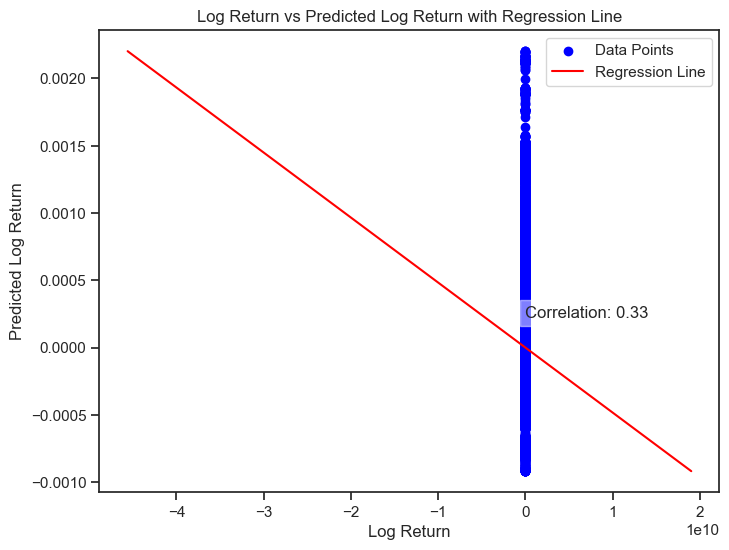

In [207]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 20, book_narrow_BTC_USD, trades_narrow_BTC_USD)

<span style="color: rgb(255,69,0);"> As shown above, increasing our tau from 10 to 20 seconds nearly doubles the R^2 of the regression while keeping the holding window T the same (20 seconds).  </span> 

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              5637.
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                        0.00
Time:                        11:38:35   Log-Likelihood:                      8.6073e+05
No. Observations:              147760   AIC:                                 -1.721e+06
Df Residuals:                  147759   BIC:                                 -1.721e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

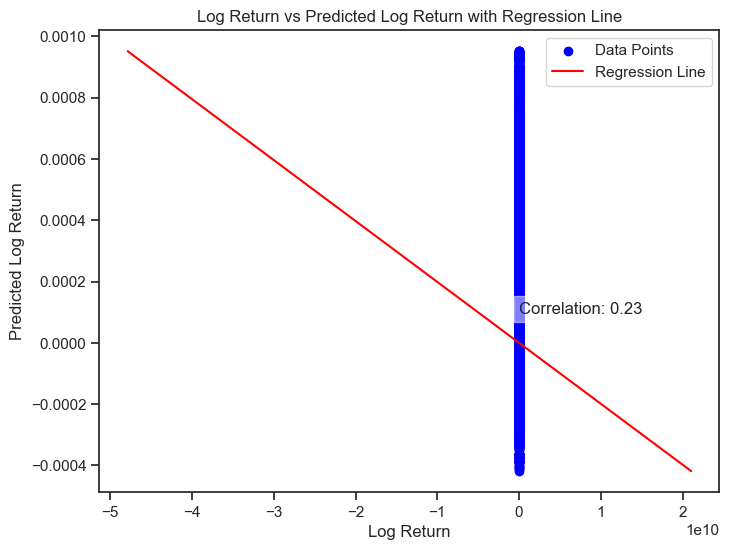

In [209]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(50, 25, book_narrow_BTC_USD, trades_narrow_BTC_USD)

<span style="color: rgb(255,69,0);"> As shown above, increasing the holding window from 20 to 25 seconds and out tau value from 20 to 50 seconds didn't yield much improvement.  </span> 

### 3.2 ETH-USD

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                nan
Time:                        11:17:15   Log-Likelihood:             6.1745e+05
No. Observations:              100086   AIC:                        -1.235e+06
Df Residuals:                  100085   BIC:                        -1.235e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Net Trade Flow     -5e-16   1.82e-17    -27.

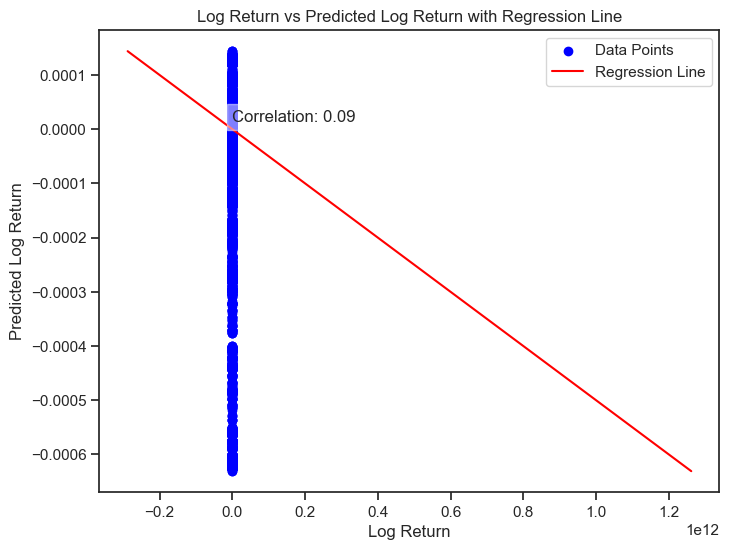

In [201]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 10, book_narrow_ETH_USD, trades_narrow_ETH_USD)

<span style="color: rgb(255,69,0);"> The OLS regression results displayed above indicate that the model for the ETH-USD cryptotoken pair has an R-squared and adjusted R-squared of -0.000, which implies that the independent variable, Net Trade Flow, does not explain any variance in the dependent variable, Return. It's unusual to see a negative R-squared, which could happen when the chosen model does not follow the trend of the data, possibly due to overfitting or using an inappropriate model for the data. The coefficient for Net Trade Flow is very close to zero (-5e-16) with an extremely small standard error, and the t-statistic is quite large and negative (-27.517), which leads to a p-value of 0.000. This indicates that the variable is statistically significant despite its negligible effect size. </span>  

<span style="color: rgb(0, 0, 128);"> The code below explores the impact of varying a threshold parameter j on trading decisions based on predicted returns within the trainStrategy dataset. Specifically, a predicted return greater than j triggers a buy decision, less than negative j triggers a sell, and anything in between results in no action. </span>

In [202]:
strategy_analysis = pd.DataFrame(columns=['Number of Trades', 'Trading Opportunities Capitalized (%)'])
strategy_analysis.index.name = 'j'

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]

strategy_analysis

,Number of Trades,Trading Opportunities Capitalized (%)
j,,
0.00001,73070.0,26.99
0.00003,95207.0,4.87
0.00005,97506.0,2.58
0.00007,98287.0,1.80
0.00009,98553.0,1.53
0.00011,98699.0,1.39
0.00013,98894.0,1.19
0.00015,99046.0,1.04
0.00017,99089.0,1.00


<span style="color: rgb(0, 0, 128);"> This code calculates and compares the profitability and return on investment (ROI) under different transaction cost scenarios. It first filters trades where the absolute value of the "Net Trade Flow" exceeds a specified threshold (optimal_j). Then, it calculates the total profit or loss (PnL) and the number of transactions that passed this filter. The ROI is computed as a percentage of the PnL relative to the number of transactions. The j value from the table above, with the closest trading opportunity capitalization rate to 5% is chosen. </span>    

In [203]:
closest_j = None
closest_capitalized = None
closest_result = None
closest_difference = float('inf')

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]
    
    # Calculate return metrics for each iteration
    result = calculate_return_metrics(strategy)
    
    # Check if the current capitalized rate is closer to 5%
    difference = abs(capitalized - 5)
    if difference < closest_difference:
        closest_difference = difference
        closest_j = j
        closest_capitalized = capitalized
        closest_result = result

print("Closest j value to 5% trading opportunity capitalization rate:", closest_j)
print("Capitalization rate:", closest_capitalized)
closest_result

Closest j value to 5% trading opportunity capitalization rate: 3.0000000000000004e-05
Capitalization rate: 4.87


,Profit and Loss (PnL),Return on Investment (%)
0% Trading cost,0.730809,0.041312
0.01% trading cost,0.553909,0.031312
1% trading cost,-16.959191,-0.958688


<span style="color: rgb(255,69,0);"> As shown above, it is very evident that the lower the trading costs are, the more profit one can generate. </span>  

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                nan
Time:                        11:40:28   Log-Likelihood:             5.8732e+05
No. Observations:              100066   AIC:                        -1.175e+06
Df Residuals:                  100065   BIC:                        -1.175e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Net Trade Flow -7.243e-16   2.45e-17    -29.

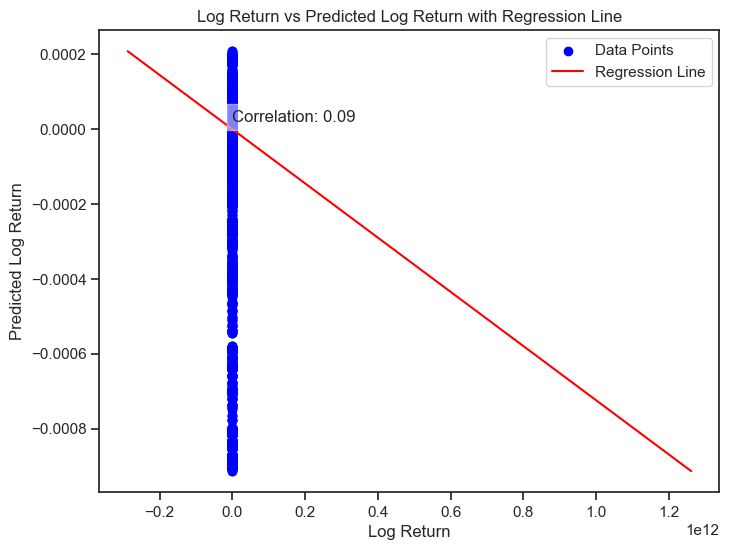

In [210]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 20, book_narrow_ETH_USD, trades_narrow_ETH_USD)

<span style="color: rgb(255,69,0);"> As shown above, increasing our tau from 10 to 20 seconds significantly improves the R^2 of the regression while keeping the holding window T the same (20 seconds) while also improving the correlation coefficient. </span> 

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                      -0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                nan
Time:                        11:41:38   Log-Likelihood:             5.7653e+05
No. Observations:              100054   AIC:                        -1.153e+06
Df Residuals:                  100053   BIC:                        -1.153e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Net Trade Flow -2.969e-16   1.55e-17    -19.

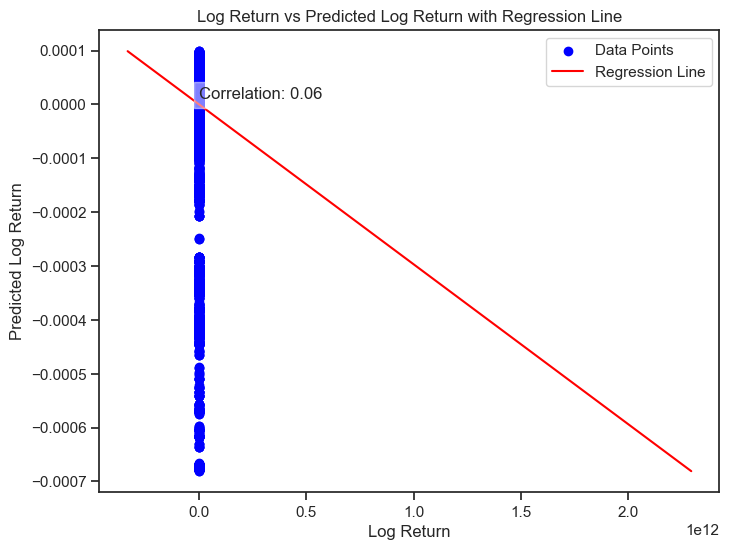

In [211]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(50, 25, book_narrow_ETH_USD, trades_narrow_ETH_USD)

<span style="color: rgb(255,69,0);"> As shown above, increasing the holding window from 20 to 25 seconds and out tau value from 20 to 50 seconds didn't yield much improvement, rather, changed our R^2 value to be -0.004.  </span> 

### 3.3 ETH-BTC

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.048
Model:                            OLS   Adj. R-squared (uncentered):              0.047
Method:                 Least Squares   F-statistic:                              37.33
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                    1.61e-09
Time:                        11:17:28   Log-Likelihood:                          4741.4
No. Observations:                 737   AIC:                                     -9481.
Df Residuals:                     736   BIC:                                     -9476.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

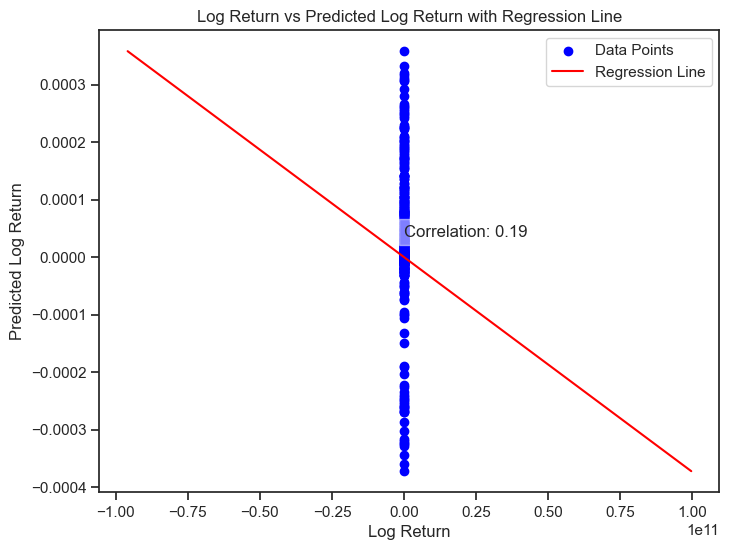

In [204]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 10, book_narrow_ETH_BTC, trades_narrow_ETH_BTC)

<span style="color: rgb(255,69,0);"> The OLS regression results presented for ETH-BTC cryptotoken shows that the model explains a small but significant portion of the variability in the dependent variable Return, with an R-squared value of 0.048. This indicates that approximately 4.8% of the variance in Return is accounted for by the model. The adjusted R-squared, which accounts for the number of predictors in the model, is very close to the R-squared value at 0.047, suggesting that the inclusion of additional predictors does not lead to overfitting. The coefficient for Net Trade Flow is -3.736e-15 with a standard error of 6.12e-16. The t-statistic for this predictor is -6.110, which indicates a highly statistically significant relationship with the dependent variable (p-value effectively at 0.00). This significance suggests that Net Trade Flow has an influence on Return, although the actual impact might be small given the magnitude of the coefficient. </span>   

<span style="color: rgb(0, 0, 128);"> The code below explores the impact of varying a threshold parameter j on trading decisions based on predicted returns within the trainStrategy dataset. Specifically, a predicted return greater than j triggers a buy decision, less than negative j triggers a sell, and anything in between results in no action. </span>

In [205]:
strategy_analysis = pd.DataFrame(columns=['Number of Trades', 'Trading Opportunities Capitalized (%)'])
strategy_analysis.index.name = 'j'

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]

strategy_analysis

,Number of Trades,Trading Opportunities Capitalized (%)
j,,
0.00001,464.0,37.04
0.00003,537.0,27.14
0.00005,571.0,22.52
0.00007,596.0,19.13
0.00009,621.0,15.74
0.00011,639.0,13.30
0.00013,650.0,11.80
0.00015,659.0,10.58
0.00017,666.0,9.63


<span style="color: rgb(0, 0, 128);"> This code calculates and compares the profitability and return on investment (ROI) under different transaction cost scenarios. It first filters trades where the absolute value of the "Net Trade Flow" exceeds a specified threshold (optimal_j). Then, it calculates the total profit or loss (PnL) and the number of transactions that passed this filter. The ROI is computed as a percentage of the PnL relative to the number of transactions. The j value from the table above, with the closest trading opportunity capitalization rate to 5% is chosen. </span> 

In [206]:
closest_j = None
closest_capitalized = None
closest_result = None
closest_difference = float('inf')

for multiplier in range(1, 50, 2):
    j = scale * multiplier
    buy_count = 0
    sell_count = 0
    no_trade_count = 0
    
    for predicted_return in trainStrategy['Predicted Return']:
        if predicted_return > j:
            buy_count += 1 
        elif predicted_return < -j:
            sell_count += 1 
        else:
            no_trade_count += 1 
    
    total_trades = buy_count + sell_count + no_trade_count
    trades_with_action = buy_count + sell_count
    capitalized = round(100 * trades_with_action / total_trades, 2) if total_trades else 0
    
    strategy_analysis.loc[j] = [no_trade_count, capitalized]
    
    # Calculate return metrics for each iteration
    result = calculate_return_metrics(strategy)
    
    # Check if the current capitalized rate is closer to 5%
    difference = abs(capitalized - 5)
    if difference < closest_difference:
        closest_difference = difference
        closest_j = j
        closest_capitalized = capitalized
        closest_result = result

print("Closest j value to 5% trading opportunity capitalization rate:", closest_j)
print("Capitalization rate:", closest_capitalized)
closest_result

Closest j value to 5% trading opportunity capitalization rate: 0.00025
Capitalization rate: 4.61


,Profit and Loss (PnL),Return on Investment (%)
0% Trading cost,0.730809,0.041312
0.01% trading cost,0.553909,0.031312
1% trading cost,-16.959191,-0.958688


<span style="color: rgb(255,69,0);"> As shown above, it is very evident that the lower the trading costs are, the more profit one can generate. </span>  

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              31.32
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                    3.08e-08
Time:                        11:42:59   Log-Likelihood:                          4697.7
No. Observations:                 737   AIC:                                     -9393.
Df Residuals:                     736   BIC:                                     -9389.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

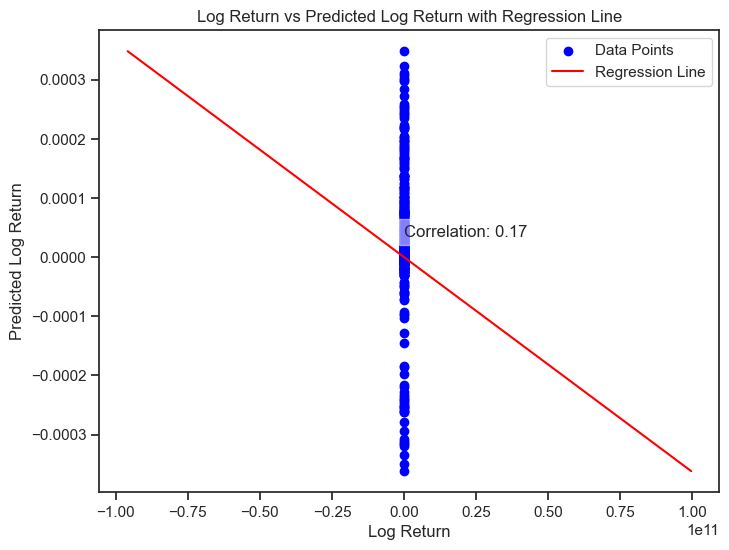

In [212]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(20, 20, book_narrow_ETH_BTC, trades_narrow_ETH_BTC)

<span style="color: rgb(255,69,0);"> As shown above, increasing our tau from 10 to 20 seconds slighly decreases the R^2 of the regression while keeping the holding window T the same (20 seconds). This was interesting because for both other crypotoken markets, R^2 significantly increased with this variation. </span> 

                                 OLS Regression Results                                
Dep. Variable:                 Return   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              31.92
Date:                Sat, 10 Feb 2024   Prob (F-statistic):                    2.30e-08
Time:                        11:44:43   Log-Likelihood:                          4648.2
No. Observations:                 737   AIC:                                     -9294.
Df Residuals:                     736   BIC:                                     -9290.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

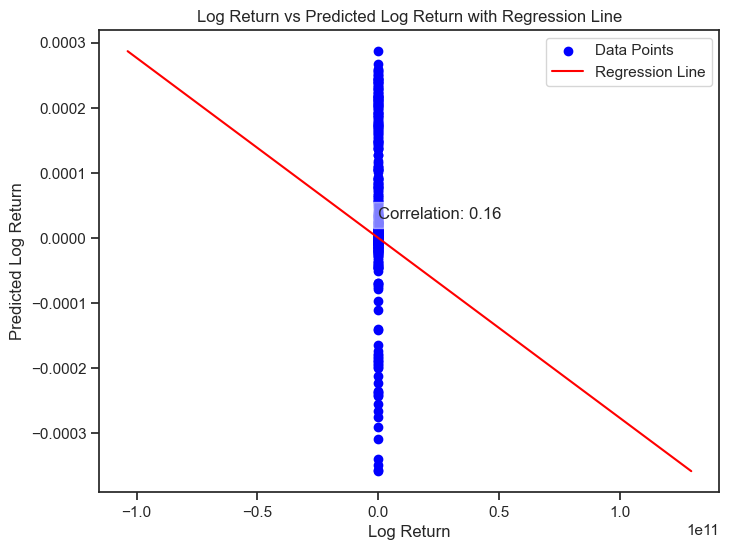

In [213]:
trainStrategy, testStrategy, summary = trade_flow_regression_strategy(50, 25, book_narrow_ETH_BTC, trades_narrow_ETH_BTC)

<span style="color: rgb(255,69,0);"> As shown above, increasing the holding window from 20 to 25 seconds and out tau value from 20 to 50 seconds didn't yield much improvement, although the R^2 did change from 0.041 to 0.042.  </span> 

## 4. External Research & Future Works

While working on this assignment, I was cruious to see the different ways one could leverage trade flow data to generate trading strategies. Below are some different strategies that can be implemented besides those tested here:

1 Utilize flow volume momentum by buying when the volume is increasing rapidly and selling when it starts to decrease. We can test this approach by analyzing the correlation between flow volume momentum and subsequent price movements, and backtest the strategy on historical data.

2 Identify divergences between flow volume and price movements to anticipate trend reversals or continuations. This can be tested by looking for instances where flow volume and price diverge and assess the effectiveness of using these divergences as trading signals.

3 Identify specific patterns in flow volume data (e.g., spikes, troughs, trends) and develop trading rules based on these patterns. A backtest to test the strategy on historical data to determine the reliability and profitability of different flow volume patterns can be conducted.

4 Integrate sentiment analysis techniques with flow volume data to gauge market sentiment and make trading decisions accordingly. We can analyze the correlation between sentiment indicators derived from flow volume and subsequent price movements.

5 Apply machine learning and AI algorithms to analyze flow volume data and identify complex patterns or relationships that may not be evident through traditional analysis.

## 5. Conclusion

In conclusion, this assignment exposed me to the concept of trade flow, how to calculate it, how to deal with data with frequencies as small as nanoseconds, along with conducting regression analysis and formulating yet a new form of trading strategy. The regression analysis for all 3 crypototoken markets yielded significant coefficients (without an intercept), however, the ETH-BTC market regression had the highest R^2 value of 0.048 while the ETH-USD market had the lowest R^2 of 0.000. This meant that although the trade flows in all 3 markets could not explain much variability in returns, they did have a significant relationship with predicted returns. In most cases, this coefficient was negative, indicating that as trade volume increased, predected returns decreased. This could be due to an increase in volatility in times of high frequency of trading. Additionally, when talking about determining optimal values for j in order to achieve a 5% trading opportunity capitalization rate, the ETH-USD market ended up having most success with a j value of 0.00023 while both BTC-USD and ETH-USD were successful with a 0.00003 j value. Finally, as expected, I also found that as trading costs were increased, the profit kept decreasing, reinforcing the concepts from last week's quantile-based trading strategy on how lower / no trading costs gave one the best outcomes. Moreover, I also analyzing changing the tau and T values for all 3 cryptotoken markets and found that for BTC-USD and ETH-USD, a tau of 20 and a T of 20 did much better than the other 2 variations (tau of 10 and holding of 20, and tau of 50 and holding of 25), however, the ETH-BTC cryptotoken market performed best for a tau of 10 and a T of 20. 